# Work from Home Sentiment on Twitter

### Intro to the project

When Covid-19 hit, most people were asked to work from home. I was curious to know how they think about it.
So I tried to find out what they are tweeting about it. 
I also wanted to know if the sentiment about working from home differs in different parts of the world.

I think it is useful to know if people are willing to work from home because the sentiment about working from home can affect productivity and influence policy making, both during COVID-19 outbreak and after that.  

In [237]:
#importing packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections

import tweepy as tw
from TwitterAPI import TwitterAPI
import nltk
from nltk.corpus import stopwords
import re
import networkx as nx
from textblob import TextBlob
from nltk import bigrams

import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale=1.8)
sns.set_style("whitegrid")

In [238]:
#Keys and Tokens From Twitter
API_key = ''
API_secret_key = ''
Token = ''
Token_secret = ''

Logging to twitter via code:

In [239]:
auth = tw.OAuthHandler(API_key, API_secret_key)
auth.set_access_token(Token, Token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

Iterating through timelines, to find search terms (work from home OR work remote):

In [240]:
search_term = "work from home OR work remote -filter:retweets AND -filter:replies"#filter out retweets and replies

tweets = tw.Cursor(api.search,
                   q=search_term,
                   lang="en").items(1000)

#for tweet in tweets:    ###incase we wanted to see the tweets to make decisions
#    print(tweet.text)

There are many URLs in the tweets, to remove them we define a function:

In [241]:
def remove_URL(text):
    """Removing URLs from the text
    input: text
    output: text with no URL"""
    #Replace the url with an empty string
    return re.sub("(\w+:\/\/\S+)", "", text)

In our basic search we don't use punctuations. They might be important in some cases but for now we can ignore them.


In [242]:
def remove_Punctuation(text):
    """Removing Punctuations from the text
    input: text
    output: text with no Punctuation"""
    punctuations = '''!()-[]{};:`\'"\,<>./?@#$%^&*_~–'''
    for char in text:
        if char in punctuations or char=='\n':
            text = text.replace(char, "")
    return text

Making a list of the tweets' text without URLs and punctuactions, and all in lower case text for doing more analysis:

In [243]:
all_tweets_text = [remove_Punctuation(remove_URL(tweet.text.lower())) for tweet in tweets]

all_tweets_text[1]#just for checking

'could working from home permanently work for your business we can help with solutions strategies and support for… '

Chacking couple of times, I have seen that there are same tweets from different locations\
or users so here we can remove duplicate tweets for better results

In [244]:

all_tweets_text = list(set(all_tweets_text))


making a list of all words from all the tweets:

In [245]:
all_words = []
for tweet in all_tweets_text:
    for word in tweet.split():
        all_words.append(word)
all_words[0:5]#to check

['🌍', 'work', 'from', 'anywhere', 'as']

Frequency of the words in the investigated tweets can help us see some trends\
and might give us better insight:

In [246]:
def word_freq(list):
    """getting the frequency of words
    input: a list
    output: dictionary with items of the list as keys
            and their frequencies in the list as the value
    """
    words_dict = {}
    for word in list:
        words_dict[word] = words_dict.get(word,0)+1
    return words_dict

In order to get a better sense on the data, we can sort the words based on the frequencies:

In [432]:
sort_orders = sorted(word_freq(all_words).items(), key=lambda x: x[1], reverse=True)

for i in sort_orders[0:15]:#just to check
    print(i)

('from', 367)
('work', 344)
('remote', 311)
('the', 309)
('to', 306)
('a', 191)
('home', 187)
('of', 174)
('and', 173)
('for', 137)
('in', 113)
('is', 111)
('working', 107)
('you', 86)
('are', 83)


Based on the results, there are many stopwords and removing them can potentially help improve\
the performance as there are fewer and only meaningful words left. 

In [248]:
nltk.download('stopwords') #Downloading stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Farzaneh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Removing stopwords and looking at the words after removing the stop words:

In [249]:
words_no_stop = [word for word in all_words if not word in stop_words]
word_sort_orders = sorted(word_freq(words_no_stop).items(), key=lambda x: x[1], reverse=True)

pd.DataFrame(word_sort_orders, columns=['word', 'freq']).head(15)

,word,freq
0,work,344
1,remote,311
2,home,187
3,working,107
4,new,69
5,employees,52
6,job,41
7,office,36
8,need,32
9,companies,30


There are some words directly related to the words used in the search or \
don't add any new information, so we can remove them:

In [250]:
 words_to_be_removed = ['work', 'remote', 'home','people','arent', 'many','looking',\
                        'could','make','us', 'one','going','a','via','doesn‘t','for','yo',\
                        'your','front','more','guard','letting','get','working','🚨','📢','still']

In [251]:
words_clean = [i for i in words_no_stop if not i in words_to_be_removed ]
words_sorted_clean = sorted(word_freq(words_clean).items(), key=lambda x: x[1], reverse=True)

Visualizing the first 30 mostcommon words in the tweets:

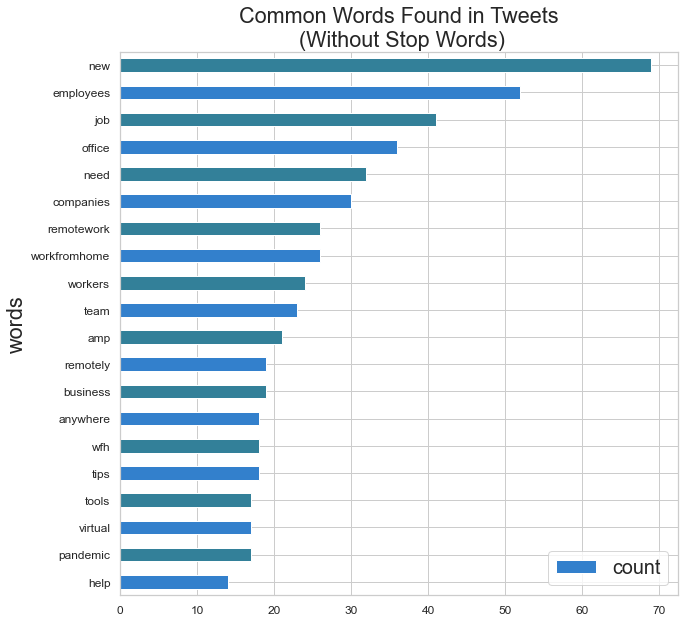

In [429]:
tweets_dataframe = pd.DataFrame(words_sorted_clean[:20],
                             columns=['words', 'count'])

fig, ax = plt.subplots(figsize=(10, 10))
import random
# Plot horizontal bar graph
tweets_dataframe.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color=[(0.2,0.5,0.8),(0.2,0.5,0.6)],fontsize=12)

ax.set_title("Common Words Found in Tweets\n (Without Stop Words)")

plt.show()

To identify co-occurrence of words in the tweets, you can use:

In [386]:
tweet_words = [tweet.split() for tweet in all_tweets_text ]#creating a list containing the words of each individual tweet
tweet_words[1:3]

[['an',
  'allinone',
  'solution',
  'for',
  'remote',
  'desktop',
  'and',
  'remote',
  'pc',
  'game',
  'with',
  'awesun',
  'no',
  'matter',
  'where',
  'you',
  'are',
  'you’re',
  'always',
  'j…'],
 ['chicagoarea',
  'teachers',
  'at',
  'higher',
  'risk',
  'for',
  'covid19',
  'hope',
  'remote',
  'work',
  'will',
  'be',
  'allowed',
  'but',
  'waiting',
  'to',
  'hear',
  'from',
  'distri…']]

Here, Since a new list is created, stopwords should be removed again

In [387]:
words_in_tweet_not_stop_word = []
for words_in_tweet in tweet_words:
    words_in_tweet_temp=words_in_tweet[:]
    for word in words_in_tweet_temp:
        if word in stop_words:
            words_in_tweet.remove(word)
        elif word in words_to_be_removed:
            words_in_tweet.remove(word)            

To identify co-occurrence of words in the tweets, you can use:

In [388]:
terms_bigram = [list(bigrams(tweet)) for tweet in tweet_words ]
terms_bigram[:3]

[[('🌍', 'anywhere'),
  ('anywhere', 'customer'),
  ('customer', 'success'),
  ('success', 'manager'),
  ('manager', 'product'),
  ('product', 'manager'),
  ('manager', 'experience'),
  ('experience', 'required'),
  ('required', 'ahaio👇'),
  ('ahaio👇', 'remote…')],
 [('allinone', 'solution'),
  ('solution', 'desktop'),
  ('desktop', 'pc'),
  ('pc', 'game'),
  ('game', 'awesun'),
  ('awesun', 'matter'),
  ('matter', 'you’re'),
  ('you’re', 'always'),
  ('always', 'j…')],
 [('chicagoarea', 'teachers'),
  ('teachers', 'higher'),
  ('higher', 'risk'),
  ('risk', 'covid19'),
  ('covid19', 'hope'),
  ('hope', 'allowed'),
  ('allowed', 'waiting'),
  ('waiting', 'hear'),
  ('hear', 'distri…')]]

Make an iterator that returns elements from the first iterable until it is exhausted, then proceeds to the next iterable, until all of the iterables are exhausted. Used for treating consecutive sequences as a single sequence.

In [389]:
bigrams_2 = list(itertools.chain(*terms_bigram))

Counting the number of times that a combination happens:

In [390]:
bigram_counts = collections.Counter(bigrams_2)

bigram_df = pd.DataFrame(bigram_counts.most_common(10),
                             columns=['bigram', 'count'])

bigram_df

,bigram,count
0,"(new, job)",12
1,"(job, listing)",9
2,"(employers, employees)",9
3,"(new, normal)",8
4,"(job, remotework)",7
5,"(poses, serious)",7
6,"(serious, dangers)",7
7,"(dangers, employers)",7
8,"(customer, service)",6
9,"(employees, alike)",6


Create dictionary of bigrams and their counts:

In [391]:
bigram_df.set_index('bigram').T.to_dict()

{('new', 'job'): {'count': 12},
 ('job', 'listing'): {'count': 9},
 ('employers', 'employees'): {'count': 9},
 ('new', 'normal'): {'count': 8},
 ('job', 'remotework'): {'count': 7},
 ('poses', 'serious'): {'count': 7},
 ('serious', 'dangers'): {'count': 7},
 ('dangers', 'employers'): {'count': 7},
 ('customer', 'service'): {'count': 6},
 ('employees', 'alike'): {'count': 6}}

In [392]:
d = bigram_df.set_index('bigram').T.to_dict('records')
d

[{('new', 'job'): 12,
  ('job', 'listing'): 9,
  ('employers', 'employees'): 9,
  ('new', 'normal'): 8,
  ('job', 'remotework'): 7,
  ('poses', 'serious'): 7,
  ('serious', 'dangers'): 7,
  ('dangers', 'employers'): 7,
  ('customer', 'service'): 6,
  ('employees', 'alike'): 6}]

In [393]:
# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

G.add_node("ref", weight=100)

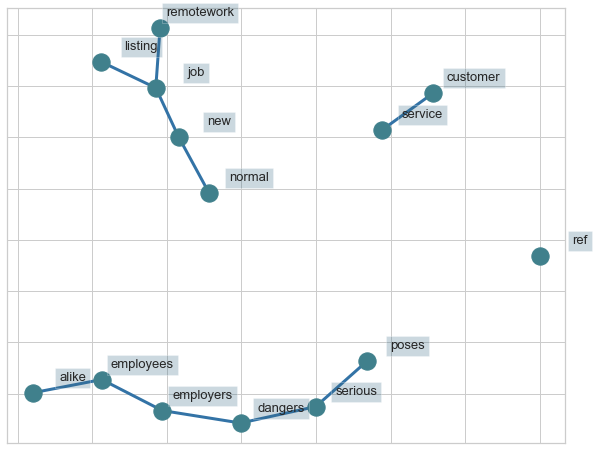

In [426]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color=(0.2,.45,0.65),
                 node_color=(0.25,0.5,0.55),
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor=(0.2,0.4,0.5), alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

## Looking at the sentiment of the tweets

In [395]:
sentiment_objects = [TextBlob(tweet) for tweet in all_tweets_text]

sentiment_objects[0].polarity, sentiment_objects[0]#just to check

(0.3,
 TextBlob("🌍 work from anywhere as a customer success manager product manager experience required for ahaio👇 remote… "))

In [396]:
sentiment_values = [[tweet.sentiment.polarity, str(tweet)] for tweet in sentiment_objects]

sentiment_values[0]#just to check

[0.3,
 '🌍 work from anywhere as a customer success manager product manager experience required for ahaio👇 remote… ']

In [398]:
sentiment_df = pd.DataFrame(sentiment_values, columns=["polarity", "tweet"])

sentiment_df.head(30)

,polarity,tweet
0,0.300000,🌍 work from anywhere as a customer success man...
1,-0.200000,an allinone solution for remote desktop and re...
2,0.075000,chicagoarea teachers at higher risk for covid1...
3,0.150000,join apa and roberthalffa for a free webinar o...
4,-0.050000,learn how covid19 has accelerated the transiti...
5,0.150000,on channel 9 enabling secure remote work using...
6,0.325000,after seeing two cohorts of summer interns suc...
7,0.000000,the santa clara county community will likely s...
8,-0.100000,lessons from a remote ceo how to create bounda...
9,-0.100000,be remote and work from anywhere


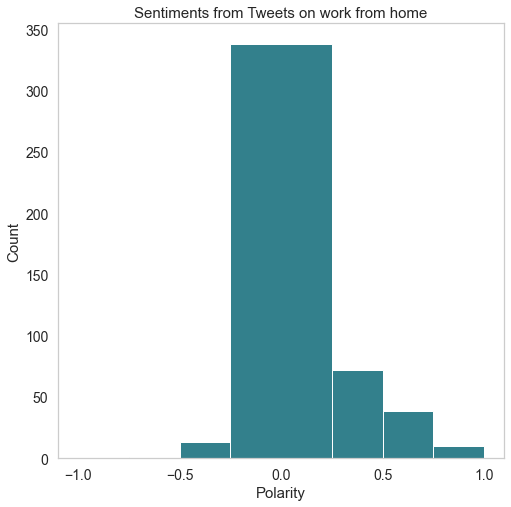

In [403]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot histogram of the polarity values
sentiment_df.hist(grid=False,bins=[-1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1],
             ax=ax,
             color=(0.2,0.5,0.55), ylabelsize=14,xlabelsize=14)

plt.title("Sentiments from Tweets on work from home",fontsize=15)
plt.xlabel('Polarity',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.show()

Polarity values equal to zero shows neutral, positive value indicates positive and negative value indicates negative feeling!

In [404]:
# Remove polarity values equal to zero
sentiment_df = sentiment_df[sentiment_df.polarity != 0]

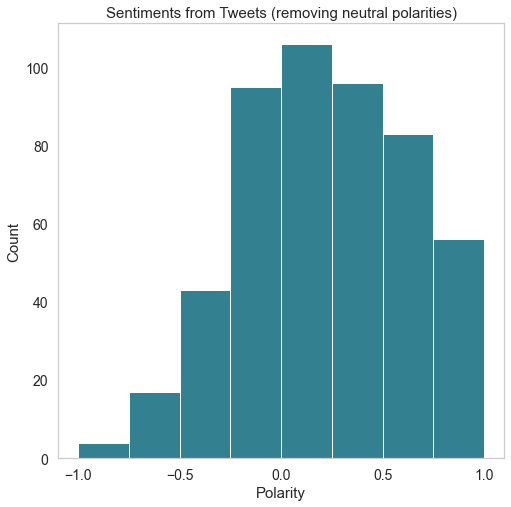

In [420]:
fig, ax = plt.subplots(figsize=(8, 8))


sentiment_df.hist(grid=False,bins=[-1, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1],
             ax=ax,
             color=(0.2,0.5,0.57),ylabelsize=14,xlabelsize=14)

plt.title("Sentiments from Tweets (removing neutral polarities)",fontsize=15)
plt.xlabel('Polarity',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.show()

# Streaming Tweets for Sentiments Based on Locations

In [406]:
api = TwitterAPI(API_key,
                API_secret_key,
                Token,
                Token_secret)
response = api.request('statuses/filter',\
                       {'track': ['work','home','remote']})

In [407]:
print(response.response)#to check if the connection has been Successful(200-->Success)

<Response [200]>


In [408]:
location = []
tweetText=[]
tweets = response.get_iterator()

We stream the tweets and if the location exists, we add the location, polarity and text to a list!

In [409]:
count = 0

while count<500:
    tweet = next(tweets)
    if 'place' in tweet and tweet['place']!=None and tweet['text']!=None:
        place = tweet['place']['full_name']#city or state
        country = tweet['place']['country']#country
        tweetText = remove_URL(tweet['text'])#tweet's text removing URL
        polarity = TextBlob(remove_URL(tweet['text'])).polarity#polarity of the tweet removing URL
        if polarity != 0 :
            location.append(( country,place, polarity, tweetText))
            count+=1


Defining states in the US, because sometimes it is abbreviations and sometimes the complete name of state:

In [411]:
states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

To be able to group the tweets based on the states we need a function to find the state from the states dict:

In [412]:
def get_key(val):
    """To find the key based on value of states dict
    input: value in the dictionary
    output: corresponding key value"""
    for key, value in states.items(): 
         if val == value: 
             return key 

Creating dataframe to be able to understand the information:

In [413]:

sentiment_df = pd.DataFrame(sorted(location), columns=["country","place",'polarity','text'])

sentiment_df.head(20)

,country,place,polarity,text
0,Australia,"Central Coast, New South Wales",0.333333,"@jishyra I left Paris because of the weather, ..."
1,Australia,"Gawler, South Australia",0.100000,@sunriseon7 If tradies can still work as they ...
2,Australia,"Gold Coast, Queensland",-0.400000,Resident slams 'piss poor' cleaning effort in ...
3,Australia,"Gold Coast, Queensland",-0.400000,Resident slams 'piss poor' cleaning effort in ...
4,Australia,"Macquarie Heads, Tasmania",0.100000,The remote and rarely visited Tiddys Beach nea...
5,Australia,"Melbourne, Victoria",0.200000,Trying to work out if it’s legal to leave home...
6,Australia,"Melbourne, Victoria",0.268182,Gonna have to start wearing all my new winter ...
7,Australia,"Mildura, Victoria",0.544444,@ScottPresler @JoeBiden You are quick mate . K...
8,Australia,"Perth, Western Australia",0.200000,@itsabelslife Will you be just working from h...
9,Australia,"Stawell, Victoria",-0.600000,A fucking disgrace by pig Andrews


we add the state to the country if the country is US:

In [414]:
for i in range(len(sentiment_df['country'])):
    if sentiment_df['country'][i] == 'United States':
        #if at the end of place column, there is a ', xx', we assume that it is the state
        if re.search(',\s\w\w$', sentiment_df['place'][i],flags=re.IGNORECASE):
            sentiment_df['country'][i] += sentiment_df['place'][i][-4:]
        #if at the end of place, there is a ', USA', we assume that before the state is before\
        #it and we get the value from statesdict
        elif re.search(',\sUSA$', sentiment_df['place'][i],flags=re.IGNORECASE):
            sentiment_df['country'][i] = sentiment_df['country'][i]+', '+get_key(sentiment_df['place'][i][:-5])
            
sentiment_df

,country,place,polarity,text
0,Australia,"Central Coast, New South Wales",0.333333,"@jishyra I left Paris because of the weather, ..."
1,Australia,"Gawler, South Australia",0.100000,@sunriseon7 If tradies can still work as they ...
2,Australia,"Gold Coast, Queensland",-0.400000,Resident slams 'piss poor' cleaning effort in ...
3,Australia,"Gold Coast, Queensland",-0.400000,Resident slams 'piss poor' cleaning effort in ...
4,Australia,"Macquarie Heads, Tasmania",0.100000,The remote and rarely visited Tiddys Beach nea...
...,...,...,...,...
495,"United States, NC","Winston-Salem, NC",0.468750,Wow Carm!! Thank God for Jesus and thank God f...
496,"United States, WI","Wisconsin, USA",1.000000,"Yes, that will be perfect! See you in the morn..."
497,"United States, OH","Zanesville, OH",0.225000,@jojoluvs18 @steveluvender He’s due to win one...
498,"United States, IN","Zionsville, IN",-0.050000,"@JoelBonnett23 Pre: Bands, long toss, pen wor..."


We can look at the polarity of tweets about work from home for each location:

In [415]:
sentiment_df.groupby('country')['polarity'].mean()
Grouped_sentiment = pd.DataFrame(sentiment_df.groupby('country')['polarity'].mean())
Grouped_sentiment

,polarity
country,
Australia,-0.004913
Bahamas,0.500000
Brasil,1.000000
Canada,0.078579
Deutschland,0.200000
...,...
"United States, VA",0.112222
"United States, WA",0.335000
"United States, WI",0.414286


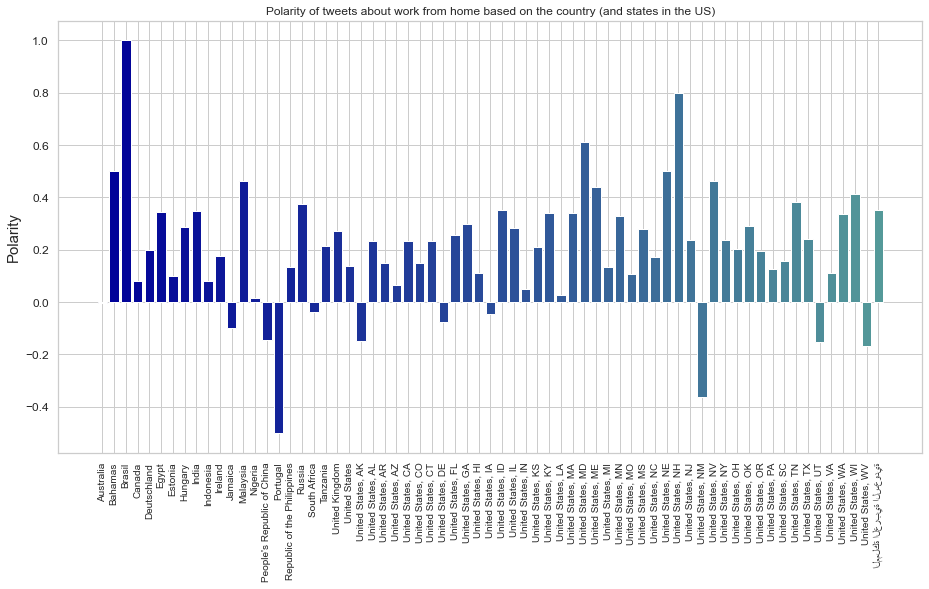

In [419]:
from itertools import cycle, islice
import pandas, numpy as np  # I find np.random.randint to be better
#my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(Grouped_sentiment['polarity'])))

fig, ax = plt.subplots(figsize=(12, 6))
#my_colors = ['g', 'b','y']*5 # <-- this concatenates the list to itself 5 times.
#my_colors = [(0.5,0.4,0.5), (0.75, 0.75, 0.25)]*5 # <-- make two custom RGBs and repeat/alternate them over all the bar elements.
my_colors = [(x/100.0, x/200.0, 0.75) for x in range(len(Grouped_sentiment['polarity']))] # <-- Quick gradient example along the Red/Green dimensions.
my_colors = [(x/200, x/110, 0.6) for x in range(len(Grouped_sentiment['polarity']))]
ax = fig.add_axes([0,0,1,1])
region = Grouped_sentiment.index
polarity = Grouped_sentiment['polarity']
ax.bar(region,polarity, color=my_colors)
plt.xticks(rotation='vertical',fontsize=10)
plt.yticks(fontsize=12)
plt.ylabel('Polarity',fontsize=15)
plt.title('Polarity of tweets about work from home based on the country (and states in the US)',fontsize=12)
fig.tight_layout()
plt.show()

## Thoughts:
From this initial test, it appears that there is generally a positive sentiment regarding working from home. I am curious to follow more of these sentiments, not only in Twitter but also in Facebook, Instagram, LinkedIn, and google searches. The next steps would be to analyze more tweets and over a longer time period. This information can then be compared with data regarding COVID-19 cases and how well a particular area has controlled the spread of the virus. Additionally, learning about the sentiment of people regarding working from home can help businesses in long-term business planning and choosing best advertisements for clothing, home improvement projects, etc. 